In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from sklearn.model_selection import KFold
import fiftyone as fo
import fiftyone.brain as fob
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy
import random

In [2]:
cudnn.benchmark = True
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

data_dir = 'plantsdata'
dataset = datasets.ImageFolder(os.path.join(data_dir))

# 80/20 split
train_dataset, val_dataset = random_split(dataset, [0.9, 0.1])

dataset_size = len(dataset)

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                           shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=True, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

class_names = dataset.classes

num_epochs = 50
batch_size = 4

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[]}
model_ft = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5582 Acc: 0.6978
val Loss: 0.5307 Acc: 0.7667

Epoch 1/99
----------
train Loss: 0.3797 Acc: 0.8268
val Loss: 0.4450 Acc: 0.8222

Epoch 2/99
----------
train Loss: 0.2861 Acc: 0.8845
val Loss: 0.3655 Acc: 0.8333

Epoch 3/99
----------
train Loss: 0.2418 Acc: 0.8894
val Loss: 0.3731 Acc: 0.8333

Epoch 4/99
----------
train Loss: 0.1718 Acc: 0.9361
val Loss: 0.3951 Acc: 0.8667

Epoch 5/99
----------
train Loss: 0.1248 Acc: 0.9595
val Loss: 0.3524 Acc: 0.8333

Epoch 6/99
----------
train Loss: 0.0979 Acc: 0.9668
val Loss: 0.2959 Acc: 0.8556

Epoch 7/99
----------
train Loss: 0.0772 Acc: 0.9828
val Loss: 0.3463 Acc: 0.8444

Epoch 8/99
----------
train Loss: 0.0639 Acc: 0.9791
val Loss: 0.2962 Acc: 0.8667

Epoch 9/99
----------
train Loss: 0.0633 Acc: 0.9791
val Loss: 0.3204 Acc: 0.8444

Epoch 10/99
----------
train Loss: 0.0621 Acc: 0.9791
val Loss: 0.2782 Acc: 0.8667

Epoch 11/99
----------
train Loss: 0.0621 Acc: 0.9803
val Loss: 0.3503 Acc: 0.8667

Ep

In [63]:
history_new = {'train_loss': history['train_loss'].copy(),
               'val_loss': history['val_loss'].copy(),
               'train_acc': [],
               'val_acc': []}
for key in ['train_acc', 'val_acc']:
    for elem in history[key]:
        history_new[key].append(elem.detach().cpu().item())

In [67]:
df = pd.DataFrame(history_new)
df

train_loss  val_loss  train_acc   val_acc
0     0.576820  0.430790   0.685306  0.859259
1     0.390554  0.330808   0.834850  0.851852
2     0.276992  0.311592   0.892068  0.888889
3     0.199594  0.279608   0.915475  0.903704
4     0.152077  0.272182   0.941482  0.888889
5     0.139206  0.324749   0.945384  0.881481
6     0.089517  0.260757   0.976593  0.911111
7     0.062301  0.231712   0.984395  0.911111
8     0.065700  0.212535   0.985696  0.903704
9     0.059114  0.253683   0.985696  0.874074
10    0.055415  0.253353   0.986996  0.911111
11    0.045581  0.250287   0.990897  0.896296
12    0.043951  0.223316   0.993498  0.918519
13    0.057628  0.252697   0.986996  0.911111
14    0.041168  0.260735   0.993498  0.881481
15    0.038926  0.248857   0.990897  0.903704
16    0.047686  0.236497   0.988296  0.896296
17    0.044452  0.246685   0.985696  0.911111
18    0.042139  0.239525   0.992198  0.911111
19    0.034043  0.258453   0.993498  0.903704
20    0.055712  0.233888   0.984395  0.925926
21    0.036809  0.245363   0.993498  0.888889
22    0.036963  0.255232   0.994798  0.896296
23    0.039264  0.248907   0.992198  0.903704
24    0.040695  0.263689   0.993498  0.881481
25    0.046714  0.277939   0.988296  0.881481
26    0.044117  0.304999   0.988296  0.896296
27    0.042990  0.236786   0.990897  0.940741
28    0.037008  0.293796   0.993498  0.888889
29    0.033433  0.242197   0.993498  0.918519
30    0.038702  0.231981   0.992198  0.896296
31    0.044133  0.225656   0.992198  0.911111
32    0.045103  0.235305   0.988296  0.925926
33    0.048956  0.257209   0.988296  0.896296
34    0.048990  0.254565   0.990897  0.896296
35    0.050165  0.271521   0.986996  0.881481
36    0.048851  0.223436   0.984395  0.918519
37    0.037578  0.233252   0.992198  0.896296
38    0.056870  0.238889   0.980494  0.911111
39    0.030565  0.292963   0.993498  0.896296
40    0.040223  0.228972   0.992198  0.903704
41    0.041459  0.246075   0.990897  0.903704
42    0.037677  0.263450   0.990897  0.903704
43    0.047407  0.273632   0.992198  0.888889
44    0.047997  0.241980   0.985696  0.911111
45    0.043608  0.230462   0.989597  0.911111
46    0.048454  0.312999   0.985696  0.866667
47    0.057154  0.274626   0.980494  0.903704
48    0.050744  0.231532   0.988296  0.903704
49    0.049543  0.229090   0.990897  0.903704

In [6]:
#### visualize_model(model_ft)
#model_ft.eval()
#torch.save(model_ft, "resnet-model-latest.pt")
model_ft = torch.load("resnet-model.pt")

In [7]:
import PIL

In [10]:
model_ft.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = PIL.Image.open("/home/zenon/test.jpg")
rgb_img = np.array(PIL.Image.open("/home/zenon/test.jpg"))
rgb_img = rgb_img.astype(np.float32)
rgb_img /= 255

data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

img = data_transforms(img)

device = "cpu"

#if "cuda" in str(device) and not torch.cuda.is_available():
#    device = "cpu"

img = img.to(device)
model_ft.to(device)
out = model_ft(img.unsqueeze(0))
torch.nn.functional.softmax(out, dim=1)[0] * 100


tensor([29.4928, 70.5072], grad_fn=<MulBackward0>)

In [47]:
from pytorch_grad_cam import *
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [model_ft.layer4[-1]]
input_tensor = img.unsqueeze(0)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_ft, target_layers=target_layers)

# Specify target for CAM (0 = healthy, 1 = stressed)
targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization_healthy = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Specify target for CAM (0 = healthy, 1 = stressed)
targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization_stressed = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [44]:
from evaluation.helpers import set_size
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [45]:
# Style the plots
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8,
                  'axes.grid': False})

fig_save_dir = '../../thesis/graphics/'

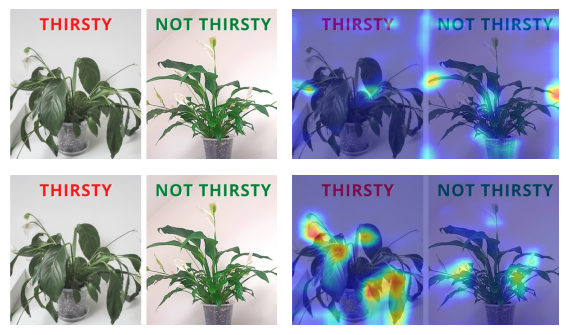

In [55]:
fig, ax = plt.subplots(2, 2, figsize=set_size(width, subplots=(2,2)))
ax[0][0].imshow(rgb_img)
ax[0][1].imshow(visualization_healthy)
ax[1][0].imshow(rgb_img)
ax[1][1].imshow(visualization_stressed)
ax[0][0].axis('off')
ax[0][1].axis('off') 
ax[1][0].axis('off') 
ax[1][1].axis('off') 
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-cam.pdf', format='pdf', bbox_inches='tight')

In [57]:
# Style the plots (with grid this time)
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8})

fig_save_dir = '../../thesis/graphics/'

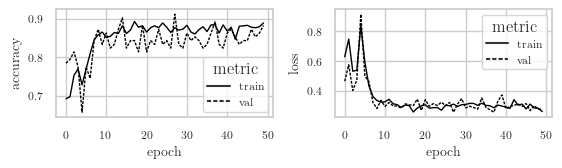

In [58]:
results = pd.read_csv('train-metrics.csv')
accs = results[['epoch', 'train_acc', 'val_acc']].rename(columns={'train_acc': 'train', 'val_acc': 'val'}).melt('epoch', var_name='metric', value_name='vals')
loss = results[['epoch', 'train_loss', 'val_loss']].rename(columns={'train_loss': 'train', 'val_loss': 'val'}).melt('epoch', var_name='metric', value_name='vals')

fig, ax = plt.subplots(1, 2, figsize=set_size(width, subplots=(1,2)))
sns.lineplot(data=loss, x='epoch', y='vals', color='black',
             style='metric', dashes=["", (2,1)],
             ax=ax[1], linewidth=1)
sns.lineplot(data=accs, x='epoch', y='vals', color='black',
             style='metric', dashes=["", (2,1)],
             ax=ax[0], linewidth=1)
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-metrics.pdf', format='pdf', bbox_inches='tight')

In [75]:
results.iloc[20:35, 4].mean()

0.84376